# **Prediction of cell viability from Cell Painting profiles**
This notebook is used to build a Random Forest model for the prediction of cell viability from Cell Painting profiles extracted with CellProfiler or Harmony.
A data oversampling algorithm can be applied to the training set to balance the number of samples in each class.


In [83]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from toxifate import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import smogn
import numpy as np
import plotly.express as px

SMOGN = 'True'

csv_per_well = "C:\\Users\\Roman\\OneDrive - National University of Ireland, Galway\\CellPainting project data\\CellProfiler\\PerWell\\blastsAllByWellProfiler.csv"
viability_file = "C:\\Users\\Roman\\OneDrive - National University of Ireland, Galway\\plate reader\\CTG-fullWellNormresults.csv"

fileFormat = 'cp' # 'harmony' or 'cp'
viability_table_per_well = pd.read_csv(viability_file)

table_per_well = pd.read_csv(csv_per_well)
if fileFormat == 'harmony':
    table_per_well = table_per_well.drop(columns=['Unnamed: 0'])
elif fileFormat == 'cp':
    table_per_well = table_per_well.drop(columns=['Unnamed: 0'])
viability_table_per_well

,Unnamed: 0,Plate,Well,1s luciferase (CPS),Row,Column,Concentration,Compound
0,0,aB1,A01,0.420143,1,1,0,none
1,1,aB1,A02,0.701689,1,2,0,none
2,2,aB1,A03,115.530466,1,3,0,none
3,3,aB1,A04,117.776712,1,4,0,none
4,4,aB1,A05,113.804258,1,5,0,none
...,...,...,...,...,...,...,...,...
9731,259,gT5,N19,107.674235,14,19,10000,ZIDO
9732,260,gT5,N20,103.564534,14,20,10000,ZIDO
9733,261,gT5,N21,102.288023,14,21,30000,ZIDO
9734,262,gT5,N22,104.278182,14,22,30000,ZIDO


In [84]:
# aggregate viability_table_per_well by Compound and Concentration, median, discard Row, Column, Unnamed: 0,Plate,Well
viability_table_per_treatment = viability_table_per_well.groupby(['Compound', 'Concentration']).median(numeric_only=True).reset_index()
viability_table_per_treatment = viability_table_per_treatment.drop(columns=['Row', 'Column', 'Unnamed: 0'])
table_per_well

,Metadata_Well,Compound,Metadata_Concentration (Image),Count,AreaShape_Area (Cells),AreaShape_BoundingBoxMaximum_X (Cells),AreaShape_BoundingBoxMaximum_Y (Cells),AreaShape_BoundingBoxMinimum_X (Cells),AreaShape_BoundingBoxMinimum_Y (Cells),AreaShape_Center_X (Cells),...,Texture_Variance_ER_3_03_256 (FilteredNuclei),Texture_Variance_MITO_3_00_256 (FilteredNuclei),Texture_Variance_MITO_3_01_256 (FilteredNuclei),Texture_Variance_MITO_3_02_256 (FilteredNuclei),Texture_Variance_MITO_3_03_256 (FilteredNuclei),Texture_Variance_RNA_3_00_256 (FilteredNuclei),Texture_Variance_RNA_3_01_256 (FilteredNuclei),Texture_Variance_RNA_3_02_256 (FilteredNuclei),Texture_Variance_RNA_3_03_256 (FilteredNuclei),PlateID
0,C10,NCAP,30,657.2,0.484584,1.550984,1.081673,1.458567,0.683639,1.580247,...,-2.561085,-0.017531,0.024250,0.012477,-0.002019,-2.246122,-2.237506,-2.245002,-2.266022,blasts1BR1
1,C11,NCAP,100,682.6,-0.157705,0.626174,-0.159741,0.724417,-0.195325,0.461126,...,-3.488014,0.548434,0.555000,0.550023,0.551534,-2.841466,-2.849422,-2.832790,-2.854318,blasts1BR1
2,C12,NCAP,100,672.2,-0.891750,1.022521,-1.474179,0.991381,-1.367278,0.729151,...,-2.929025,0.550452,0.545393,0.559650,0.545094,-2.475362,-2.475448,-2.478485,-2.488753,blasts1BR1
3,C13,NCAP,300,676.4,0.805729,-0.893158,-0.597887,-0.476920,-1.074290,-0.821232,...,-3.766243,-0.531848,-0.522584,-0.506716,-0.504337,-3.265408,-3.266243,-3.265458,-3.272163,blasts1BR1
4,C14,NCAP,300,679.6,-0.845872,0.361942,-0.378814,-0.076474,-0.122078,0.049733,...,-2.979573,0.046328,0.088113,0.065387,0.071783,-2.828945,-2.840122,-2.832672,-2.833497,blasts1BR1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3355,N5,DMSO,0,681.2,-1.852676,-0.994764,-0.596370,-0.536708,-0.212692,-0.767186,...,0.693776,0.208117,0.217832,0.158043,0.177694,1.386461,1.362714,1.368679,1.375872,blasts5BR3
3356,N6,DMSO,0,626.6,1.364189,-0.596858,0.775472,-1.038565,1.125411,-0.960687,...,-1.253214,-1.173570,-1.142655,-1.190879,-1.169022,-1.124650,-1.124888,-1.110066,-1.117168,blasts5BR3
3357,N7,ZIDO,10,624.8,1.498225,-0.845549,-0.939331,-0.938193,-0.510049,-0.950975,...,-1.439188,-2.232664,-2.199772,-2.131945,-2.141157,-1.336880,-1.341865,-1.356299,-1.328229,blasts5BR3
3358,N8,ZIDO,10,661.4,-0.217436,0.795811,0.226735,0.968863,-0.807405,0.824993,...,-1.788869,-2.272898,-2.184796,-2.197992,-2.173862,-1.799917,-1.751446,-1.758930,-1.773001,blasts5BR3


In [85]:
if fileFormat == 'cp':
    table_per_well.rename(columns={'Metadata_Compound':'Compound', 'Metadata_Concentration (Image)':'Concentration','Metadata_Well':'Well'}, inplace=True)
    table_per_well.drop(columns=['PlateID','Well'], inplace=True)

# aggregate table_per_well by Compound and Concentration, median, discard Row and Column
table_per_treatment = table_per_well.groupby(['Compound', 'Concentration']).median(numeric_only=True).reset_index()
table_per_treatment.drop(columns=['Row', 'Column'], inplace=True, errors='ignore')
table_per_treatment.insert(loc=3, column='Viability', value=viability_table_per_treatment['1s luciferase (CPS)'])
table_per_treatment.head()
#remove columns with too many missing values
table_per_treatment = table_per_treatment.dropna(axis=1)
table_per_treatment


#plot the distribution of Viability values with a displot (kde), by Compound

#sns.displot(data=table_per_treatment.loc[table_per_treatment['Compound'] != 'DMSO'], x="Viability", hue="Compound", kind="kde", fill=True, col='Compound', col_wrap=6,facet_kws=dict(sharey=False),cut=0, legend=False)

,Compound,Concentration,Count,Viability,AreaShape_Area (Cells),AreaShape_BoundingBoxMaximum_X (Cells),AreaShape_BoundingBoxMaximum_Y (Cells),AreaShape_BoundingBoxMinimum_X (Cells),AreaShape_BoundingBoxMinimum_Y (Cells),AreaShape_Center_X (Cells),...,Texture_Variance_ER_3_02_256 (FilteredNuclei),Texture_Variance_ER_3_03_256 (FilteredNuclei),Texture_Variance_MITO_3_00_256 (FilteredNuclei),Texture_Variance_MITO_3_01_256 (FilteredNuclei),Texture_Variance_MITO_3_02_256 (FilteredNuclei),Texture_Variance_MITO_3_03_256 (FilteredNuclei),Texture_Variance_RNA_3_00_256 (FilteredNuclei),Texture_Variance_RNA_3_01_256 (FilteredNuclei),Texture_Variance_RNA_3_02_256 (FilteredNuclei),Texture_Variance_RNA_3_03_256 (FilteredNuclei)
0,ATOR,10,645.7,98.262090,0.723791,0.305633,0.241893,0.029278,0.207533,0.274138,...,-1.190034,-1.188338,-0.334331,-0.326266,-0.339149,-0.328388,-1.235518,-1.178616,-1.229783,-1.212236
1,ATOR,30,657.1,94.406498,0.999172,-0.298637,-0.146189,-0.488954,-0.253092,-0.496457,...,-2.006949,-2.013204,-0.274977,-0.289293,-0.308476,-0.254404,-2.078155,-2.088527,-2.090760,-2.067423
2,ATOR,100,647.6,95.387465,0.628366,-0.518878,-0.295854,-0.743883,-0.127215,-0.441306,...,-2.376642,-2.334488,-0.159984,-0.150268,-0.148988,-0.136117,-2.493095,-2.498927,-2.472790,-2.489648
3,ATOR,300,657.1,91.679638,0.628307,-0.374398,0.205381,-0.443549,0.354027,-0.282174,...,-2.943113,-2.907084,-0.359665,-0.362409,-0.373531,-0.361484,-3.071297,-3.011046,-3.075821,-3.084995
4,ATOR,1000,652.8,93.215158,0.818909,-0.430752,0.419207,-0.226666,0.272192,-0.379705,...,-3.457275,-3.449132,-0.524304,-0.526783,-0.506650,-0.506339,-3.996620,-3.978206,-3.919076,-3.980616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,ZIDO,300,608.9,103.726408,4.157989,-0.348167,0.530970,-0.608693,0.365170,-0.395814,...,-2.813843,-2.820691,-1.335125,-1.386905,-1.307800,-1.372935,-3.489625,-3.473026,-3.499415,-3.456903
237,ZIDO,1000,602.1,101.589529,5.971247,-0.149339,-0.767850,-0.388816,-0.609040,-0.312922,...,-3.201052,-3.188979,-1.442472,-1.446925,-1.447412,-1.504539,-4.048124,-4.039520,-4.060838,-4.054396
238,ZIDO,3000,558.0,98.338109,7.693716,-0.049738,0.743277,-0.250638,0.014930,-0.317881,...,-3.294677,-3.296510,-1.561753,-1.555932,-1.556475,-1.560844,-4.242535,-4.220498,-4.258327,-4.242408
239,ZIDO,10000,552.0,99.459198,12.010221,0.567874,0.135141,0.156663,-0.749401,0.402412,...,-3.464383,-3.457420,-0.460019,-0.493190,-0.436575,-0.462047,-4.368712,-4.366521,-4.409481,-4.381157


r_index: 100%|##########| 20/20 [00:04<00:00,  4.90it/s]


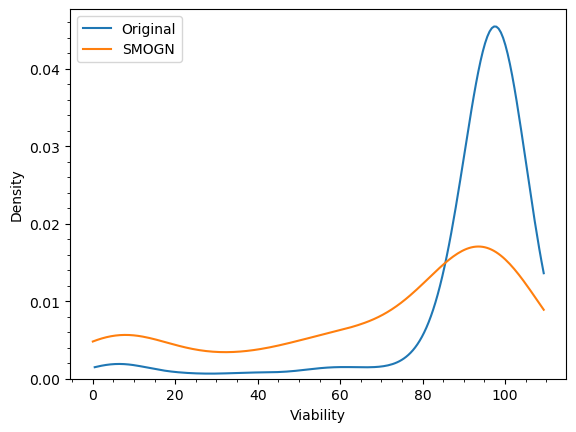

In [86]:
#remove correlated features from table_per_treatment
#table_per_treatment = Drop_correlated_columns(table_per_treatment, 0.9)

#oversample the data to balance the Viability values between 0 and 100
augmentedData = smogn.smoter(data = table_per_treatment, y = "Viability", rel_xtrm_type = "low", samp_method='balance',
                             rel_coef = 5)
sns.kdeplot(table_per_treatment['Viability'], label = "Original", cut=0)
sns.kdeplot(augmentedData['Viability'], label = "SMOGN",cut=0)
#add minor ticks to x axis 
plt.minorticks_on()
plt.legend()

In [87]:
if SMOGN == 'False':
    augmentedData = table_per_treatment



#train a random forest regressor to predict viability from the other features
#split the data into train and test sets
augmentedData.reset_index(drop=True, inplace=True)
augmentedData = augmentedData.sample(frac=1).reset_index(drop=True) # shuffle rows to avoid chunks of same drugs with stratified cv
X = augmentedData.drop(columns=['Compound', 'Concentration', 'Viability','Count'])
y = augmentedData['Viability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#train the model
rf = RandomForestRegressor(n_estimators=100, random_state=72)
rf.fit(X_train, y_train)

#predict the viability values for the test set
y_pred = rf.predict(X_test)

#calculate the mean squared error and the R2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)




# merge y_test and y_pred into a dataframe, and add the Compound and Concentration columns using merge

y_test = pd.DataFrame(y_test)
y_test['Predicted Viability'] = y_pred
y_test = y_test.merge(augmentedData[['Compound', 'Concentration']], left_index=True, right_index=True)



In [94]:

#plot the actual and predicted viability values for each compound
fig = px.scatter(y_test, x="Viability", y="Predicted Viability", color="Compound", hover_data=['Concentration'], trendline="ols", trendline_scope='overall',height=1000, width=1200)
fig.update_traces(marker={'size': 10})
fig.update_layout(
    font=dict(
        size=18,
        color="black"
    )
)
fig.show()

print('Mean squared error: ', mse)
print('R2 score: ', r2)


Mean squared error:  154.46989342529196
R2 score:  0.8747729989489617


In [95]:
y_train = pd.DataFrame(y_train)
y_train['Predicted Viability'] = rf.predict(X_train)
y_train = y_train.merge(augmentedData[['Compound', 'Concentration']], left_index=True, right_index=True)


0.990067566064187

In [96]:

fig2 = px.scatter(y_train, x="Viability", y="Predicted Viability", color="Compound", hover_data=['Concentration'], trendline="ols", trendline_scope='overall',height=1000, width=1200)
fig2.update_traces(marker={'size': 8})

fig2.update_traces(marker={'size': 10})
fig2.update_layout(
    font=dict(
        size=18,
        color="black"
    )
)
fig2.show()
r2_score(y_train['Viability'], y_train['Predicted Viability'])

0.990067566064187

In [81]:
#calculate the feature importance
feature_importances = pd.DataFrame(rf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(15)

,importance
Granularity_2_ER (FilteredNuclei),0.358767
Granularity_4_ER (Cytoplasm),0.125132
Granularity_2_RNA (FilteredNuclei),0.096380
Texture_InverseDifferenceMoment_DNA_3_00_256 (Cytoplasm),0.057619
Granularity_3_RNA (Cells),0.044074
Granularity_3_ER (Cells),0.029807
RadialDistribution_FracAtD_DNA_2of4 (FilteredNuclei),0.024309
AreaShape_Eccentricity (Cytoplasm),0.018494
RadialDistribution_MeanFrac_DNA_1of4 (Cells),0.015521
Granularity_4_RNA (Cytoplasm),0.014902


In [62]:
#now perform cross-validation to get a better estimate of the model performance, and plot the predicted vs actual values
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print('R2 scores: ', scores)
print('Mean R2 score: ', scores.mean())

R2 scores:  [0.87188091 0.91649292 0.89186148 0.91639581 0.90902414]
Mean R2 score:  0.9011310506106159


In [63]:

#plot the predicted vs actual values, and display the regression line and R2 score
from sklearn.model_selection import cross_val_predict
import plotly.express as px
augmentedData = augmentedData.reset_index(drop=True)
#randomize row order
X = augmentedData.drop(columns=['Compound', 'Concentration', 'Viability','Count'])
y = augmentedData['Viability']

y_pred = cross_val_predict(rf, X, y, cv=5)
# add back the compound and concentration columns
y_pred = pd.DataFrame(y_pred, columns=['Viability'])
y_pred = pd.concat([augmentedData[['Compound', 'Concentration']], y_pred], axis=1)
augmentedData['Prediction'] = y_pred['Viability']

fig = px.scatter(augmentedData, x="Viability", y="Prediction", trendline="ols", title='Treat level (Cross-Validation)', hover_data=['Compound', 'Concentration'],
                 height=1000, width=1000, trendline_scope = 'overall', color='Compound')
fig.update_layout(title='Well level (Cross-Validation)',
                     xaxis_title='Actual Viability',
                     yaxis_title='Predicted Viability')


fig.show()
r2_cv = r2_score(augmentedData['Viability'], augmentedData['Prediction'])
print('Cross-validated R2 score: ', r2_cv)

Cross-validated R2 score:  0.9063935283331807


In [64]:
# run the same analysis without aggregation
table_per_well2 = table_per_well.drop(columns=['Row', 'Column', 'PlateName'], errors='ignore')

#join viability data to the table_per_well, on Compound and Concentration columns
per_well_withviability = table_per_well2.merge(viability_table_per_treatment, on=['Compound', 'Concentration'])
#drop Unnamed: 0, Plate, Well, all columns ending with _y, and rename 1s luciferase (CPS) to Viability
per_well_withviability.rename(columns={'1s luciferase (CPS)': 'Viability'}, inplace=True)
per_well_withviability

,Compound,Concentration,Count,AreaShape_Area (Cells),AreaShape_BoundingBoxMaximum_X (Cells),AreaShape_BoundingBoxMaximum_Y (Cells),AreaShape_BoundingBoxMinimum_X (Cells),AreaShape_BoundingBoxMinimum_Y (Cells),AreaShape_Center_X (Cells),AreaShape_Center_Y (Cells),...,Texture_Variance_ER_3_03_256 (FilteredNuclei),Texture_Variance_MITO_3_00_256 (FilteredNuclei),Texture_Variance_MITO_3_01_256 (FilteredNuclei),Texture_Variance_MITO_3_02_256 (FilteredNuclei),Texture_Variance_MITO_3_03_256 (FilteredNuclei),Texture_Variance_RNA_3_00_256 (FilteredNuclei),Texture_Variance_RNA_3_01_256 (FilteredNuclei),Texture_Variance_RNA_3_02_256 (FilteredNuclei),Texture_Variance_RNA_3_03_256 (FilteredNuclei),Viability
0,NCAP,30,657.2,0.484584,1.550984,1.081673,1.458567,0.683639,1.580247,1.136553,...,-2.561085,-0.017531,0.024250,0.012477,-0.002019,-2.246122,-2.237506,-2.245002,-2.266022,96.597931
1,NCAP,30,678.4,0.163440,-1.884026,1.008649,-1.811738,0.756886,-1.909827,1.086644,...,-2.671342,-0.385313,-0.344760,-0.351456,-0.351843,-2.402328,-2.397610,-2.414436,-2.418905,96.597931
2,NCAP,30,653.6,1.585652,0.229826,-0.159741,0.724417,-0.341819,0.508658,-0.308365,...,-1.972640,-0.798323,-0.780569,-0.789076,-0.805890,-1.666951,-1.688319,-1.653058,-1.656130,96.597931
3,NCAP,30,678.8,-0.088888,-0.496810,0.351430,-0.209956,-0.195325,-0.285052,0.082756,...,-1.983882,-0.272515,-0.281053,-0.261342,-0.237133,-1.710806,-1.736869,-1.722915,-1.720094,96.597931
4,NCAP,30,688.4,-1.406359,-2.269490,0.179625,-2.115838,0.544482,-2.251701,0.249832,...,-0.903040,-0.101623,-0.147450,-0.117662,-0.062600,-2.288013,-2.290764,-2.365198,-2.329030,96.597931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3275,ZIDO,10,635.4,0.979674,0.297763,0.135141,0.589736,0.364955,0.513444,0.368862,...,-1.707316,-0.998949,-1.043873,-1.021137,-1.048704,-1.536208,-1.549852,-1.536072,-1.525473,101.228239
3276,ZIDO,10,635.8,1.069310,0.596858,-0.184818,0.567377,-0.510049,0.450926,-0.368965,...,-1.186714,-2.597369,-2.622536,-2.619828,-2.578199,-0.855171,-0.826253,-0.851512,-0.885756,101.228239
3277,ZIDO,10,638.2,0.318708,-0.198953,-1.145107,0.266263,-1.253440,0.030010,-1.335544,...,-1.666207,-1.973629,-2.059334,-2.027878,-1.933142,-1.493846,-1.499028,-1.465447,-1.482572,101.228239
3278,ZIDO,10,624.8,1.498225,-0.845549,-0.939331,-0.938193,-0.510049,-0.950975,-0.743367,...,-1.439188,-2.232664,-2.199772,-2.131945,-2.141157,-1.336880,-1.341865,-1.356299,-1.328229,101.228239


In [65]:
augmentedData2 = smogn.smoter(data = per_well_withviability, y = "Viability", rel_xtrm_type = "low")
sns.kdeplot(per_well_withviability['Viability'], label = "Original", cut=0)
sns.kdeplot(augmentedData2['Viability'], label = "SMOGN",cut=0)
plt.legend()

dist_matrix:   8%|7         | 47/622 [07:59<1:37:46, 10.20s/it]


KeyboardInterrupt: 

In [ ]:
#train a random forest regressor to predict viability from the other features
#split the data into train and test sets
curatedData = drop_correlated_columns(per_well_withviability.query('Viability < 97'), 0.9, numeric=True)
X2 = curatedData.drop(columns=['Compound', 'Concentration', 'Viability','Count']).dropna(axis=1)
y2 = curatedData['Viability']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.1, random_state=111)

#train the model
rf2 = RandomForestRegressor(n_estimators=100, random_state=72)
rf2.fit(X_train2, y_train2)

#predict the viability values for the test set
y_pred2 = rf2.predict(X_test2)

#calculate the mean squared error and the R2 score
mse2 = mean_squared_error(y_test2, y_pred2)
r22 = r2_score(y_test2, y_pred2)
print('Mean squared error: ', mse)
print('R2 score: ', r22)


Mean squared error:  13.086567522067755
R2 score:  0.8928685729193934


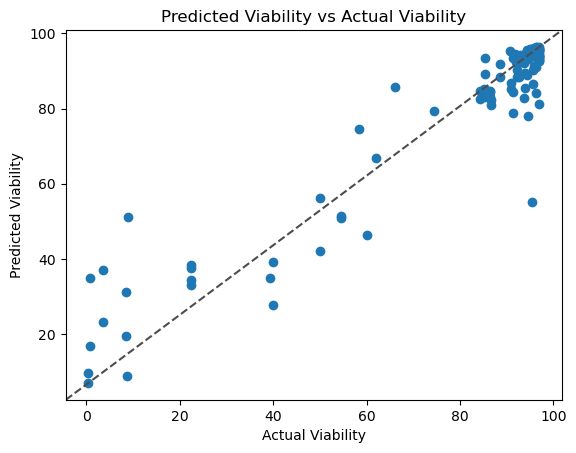

In [ ]:

#add the regression line to the plot, make the plot square
plt.scatter(y_test2, y_pred2 )
plt.xlabel('Actual Viability')
plt.ylabel('Predicted Viability')
plt.title('Predicted Viability vs Actual Viability')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls="--", c=".3")
plt.show()

In [ ]:
feature_importances2 = pd.DataFrame(rf2.feature_importances_, index = X_train2.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances2.head(10)

,importance
Cytoplasm 488 Profile 4/5 SER-Edge,0.350247
Nucleus 33342 Profile 5/5,0.178366
Cytoplasm Mito Profile 4/5 SER-Bright,0.123103
Cytoplasm 33342 Profile 3/5 SER-Hole,0.016715
Cytoplasm 33342 Profile 3/5 SER-Edge,0.012692
Cytoplasm 488 Profile 3/5 SER-Dark,0.011226
Cell 33342 Radial Mean,0.011040
Cell 488 Radial Mean Ratio SER-Dark,0.009542
Intensity Cytoplasm Alexa 568 Mean,0.008704
Nucleus 33342 Radial Mean Ratio SER-Bright,0.008264


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
cv_scores = cross_val_score(rf2, X2, y2, cv=ShuffleSplit(n_splits=5, test_size=0.1, random_state=0))

print("Cross-validation scores: ", cv_scores)
print("Mean score: ", np.mean(cv_scores))
print("Standard deviation: ", np.std(cv_scores))


Cross-validation scores:  [0.88944951 0.83283827 0.87190141 0.89354614 0.86880426]
Mean score:  0.8713079173678405
Standard deviation:  0.021495068675252357
